In [14]:
import itertools
import pickle
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from SuchTree import SuchTree

sns.set_theme(
    style="ticks",
    palette="colorblind",
    rc={
        "axes.spines.right": False,
        "axes.spines.top": False,
        "legend.frameon": False,
        "figure.dpi": 100,
        "legend.handlelength": 1,
        "legend.handletextpad": 0.5,
    },
)

In [3]:
def tukey_biweight(vector, c=9, epsilon=1e-4):
    m = np.median(vector)
    s = np.median(np.abs(vector - m))
    u = (vector - m) / ((c * s) + epsilon)
    i = np.abs(u) > 1
    w = (1 - u**2) ** 2
    w[i] = 0
    tbi = np.sum(w * vector) / np.sum(w)
    return tbi

In [4]:
def get_pair_distance(tree, node_1, node_2):
    """
    Get the phylogenetic distance between a pair of genomes. The phyloegentic
    distance is defined as the distance between the node of their most recent
    common ancestor and the genomes' leaves in the tree. This value ranges
    from 0 (close genomes) to 1 (distant genomes).
    """
    node_1 = tree.leafs[node_1]
    node_2 = tree.leafs[node_2]
    if node_1 == node_2:
        return 0
    else:
        mrca = tree.mrca(node_1, node_2)
        mrca_root_distance = tree.get_distance_to_root(mrca)
        max_distance_to_root = max(
            tree.get_distance_to_root(i) for i in (node_1, node_2)
        )
        return 1 - (mrca_root_distance / max_distance_to_root)

In [5]:
def get_average_host_distance(host_list, tree):
    """
    Get the average distance of all the genomes in a list containing the
    accessions of host genomes.
    """
    total_dist = 0
    host_counts = Counter(host_list)
    if len(host_counts) == 1:
        return 0
    total_n = 0
    for host_pair in itertools.combinations_with_replacement(host_counts, 2):
        if host_pair[0] == host_pair[1]:
            n = host_counts[host_pair[0]] * (host_counts[host_pair[0]] - 1)
        else:
            n = host_counts[host_pair[0]] * host_counts[host_pair[1]]
        total_dist += get_pair_distance(tree, *host_pair) * n
        total_n += n
    return total_dist / total_n

In [6]:
def get_complete_host_distance(host_list, tree):
    """
    Get the expected distance of all the genomes in a list containing the
    accessions of host genomes. The expected distance is computed using the mean,
    median, Q1, Q3, and Tukey biweight of the pairwise distances between all genomes
    in the list.
    """
    dists = []
    host_counts = Counter(host_list)
    if len(host_counts) == 1:
        return (0.0, 0.0, 0.0, 0.0, 0.0)
    for host_pair in itertools.combinations_with_replacement(host_counts, 2):
        if host_pair[0] == host_pair[1]:
            n = host_counts[host_pair[0]] * (host_counts[host_pair[0]] - 1)
        else:
            n = host_counts[host_pair[0]] * host_counts[host_pair[1]]
        dists.extend([get_pair_distance(tree, *host_pair)] * n)
    return (
        np.mean(dists),
        np.median(dists),
        np.percentile(dists, 25),
        np.percentile(dists, 75),
        tukey_biweight(dists),
    )

---

# Phylogenetic distance metric

Here, we will define a phylogenetic distance metric that will be used to estimate the host range of prophage clusters. This metric is obtained using the `get_pair_distance` function, which computes the distance between pais of genomes as the distance between the node of their most recent common ancestor and the leaves of the genomes. The metric ranges from 0 (close genomes) to 1 (distant genomes).

First, a GTDB tree was rerooted at the Patescibacteria (using the `reroot_tree.py` script) and then RED-scaled using `PhyloRank`. This tree then loaded into the environment using `DendroPy` and all the node to root distances are computed and stored in the ree object (`tree`).

In [6]:
tree = SuchTree("gtdb_data/bac120_r207.rerooted.scaled.tree")
taxa_in_tree = [i for i in tree.leafs.keys()]

The GTDB r207 metadata is then loaded into a `DataFrame` object and columns for each taxonomic rank (domain → species) are created. Next, the rows corresponding to genomes that are in the tree are selected.

In [7]:
gtdb_metadata = pd.read_csv("gtdb_data/bac120_taxonomy_r207.tsv", sep="\t", header=None)
gtdb_metadata.columns = ["Genome", "Taxonomy"]
gtdb_taxonomy = gtdb_metadata["Taxonomy"].str.split(";", expand=True)
gtdb_taxonomy.columns = [
    "Domain",
    "Phylum",
    "Class",
    "Order",
    "Family",
    "Genus",
    "Species",
]
gtdb_taxonomy.index = gtdb_metadata["Genome"].values
gtdb_taxonomy = gtdb_taxonomy.reindex(taxa_in_tree)

---

# Quantify host range breadth

To measure the host range of a given plasmid in a quantitative manner we will measure the pairwise distances of all the hosts infected by the each plasmid. First, we will create a dictionary (`species_genome_dict`) associating a given genome accession to the accession of the species representative, so it can be queried in the tree.

In [8]:
species_genome_dict = {row.Species: row.Index for row in gtdb_taxonomy.itertuples()}

Read the CRISPR spacer hit data and then use it to create the `virus_hosts_crispr` and `virus_hosts_kmers` dictionaries. These objects store, for each virus, a list containing the representatives for all the species that are infected by it, which were identified using CRISPR spacer and k-mer matching, respectively. This will be performed for a subset of vOTUs whose representative genome is medium-quality or better and that has a confident virus prediction.

In [9]:
conservative_set = set()
with open("uhgv_data/votus_metadata.tsv") as fin:
    next(fin)
    for line in fin:
        line = line.strip("\n").split("\t")
        votu = line[1]
        checkv_quality = line[3]
        viral_confidence = line[4]
        if (
            checkv_quality not in {"Low-quality", "Not-determined"}
            and viral_confidence == "Confident"
        ):
            conservative_set.add(votu)

In [10]:
USE_CONSERVATIVE_SET = True
virus_hosts_crispr = defaultdict(list)
virus_hosts_kmers = defaultdict(list)
# Host species determined via CRISPR
with open("uhgv_data/votu_host_species.tsv") as fin:
    for line in fin:
        virus, host_species = line.strip().split("\t")
        if USE_CONSERVATIVE_SET and virus not in conservative_set:
            continue
        # Check if the host is in the `species_genome_dict` dictionary
        # (that is, if it is not an Archaea)
        for host in host_species.split(";"):
            if host in species_genome_dict:
                virus_hosts_crispr[virus].append(species_genome_dict[host])
# Host species determined via kmer matching
with open("uhgv_data/votu_host_species_kmers.tsv") as fin:
    for line in fin:
        virus, host_species = line.strip().split("\t")
        if USE_CONSERVATIVE_SET and virus not in conservative_set:
            continue
        for host in host_species.split(";"):
            if host in species_genome_dict:
                virus_hosts_kmers[virus].append(species_genome_dict[host])

To have a single value representing the host range of a given vOTU, we compute a central tendency for the pairwise distances of the host genomes connected to each vOTU. The central tendency is measured using the mean, median, and host genomes. These values are stored in the `virus_host_dist_crispr` and `virus_host_dist_kmers` dictionaries.

In [14]:
virus_host_dist_crispr = {}
virus_host_dist_kmers = {}
# Distance between host genomes determined via CRISPR
for virus, hosts in virus_hosts_crispr.items():
    (
        mean_dist,
        median_dist,
        q1_dist,
        q3_dist,
        tukey_biweight_dist,
    ) = get_complete_host_distance(hosts, tree)
    virus_host_dist_crispr[virus] = {
        "n_host_genomes": len(hosts),
        "mean_dist": mean_dist,
        "median_dist": median_dist,
        "q1_dist": q1_dist,
        "q3_dist": q3_dist,
        "tukey_biweight_dist": tukey_biweight_dist,
    }
# Distance between host genomes determined via kmer matching
for virus, hosts in virus_hosts_kmers.items():
    (
        mean_dist,
        median_dist,
        q1_dist,
        q3_dist,
        tukey_biweight_dist,
    ) = get_complete_host_distance(hosts, tree)
    virus_host_dist_kmers[virus] = {
        "n_host_genomes": len(hosts),
        "mean_dist": mean_dist,
        "median_dist": median_dist,
        "q1_dist": q1_dist,
        "q3_dist": q3_dist,
        "tukey_biweight_dist": tukey_biweight_dist,
    }

To compile a unified table containing the host range values for all the vOTUs, the results from the CRISPR and k-mer-based approaches are merged. For vOTUs that were assigned to host genomes by both methods, the method that connected the vOTU to the largest number of host genomes is selected.

In [34]:
virus_host_dist_combined = {}
for k in set(virus_host_dist_crispr).union(virus_host_dist_kmers):
    if (k in virus_host_dist_crispr) and (k in virus_host_dist_kmers):
        if (
            virus_host_dist_crispr[k]["n_host_genomes"]
            >= virus_host_dist_kmers[k]["n_host_genomes"]
        ):
            virus_host_dist_combined[k] = virus_host_dist_crispr[k]
            virus_host_dist_combined[k]["method"] = "crispr_spacer"
        elif (
            virus_host_dist_crispr[k]["n_host_genomes"]
            < virus_host_dist_kmers[k]["n_host_genomes"]
        ):
            virus_host_dist_combined[k] = virus_host_dist_kmers[k]
            virus_host_dist_combined[k]["method"] = "kmer_matching"
    elif k in virus_host_dist_crispr:
        virus_host_dist_combined[k] = virus_host_dist_crispr[k]
        virus_host_dist_combined[k]["method"] = "crispr_spacer"
    else:
        virus_host_dist_combined[k] = virus_host_dist_kmers[k]
        virus_host_dist_combined[k]["method"] = "kmer_matching"

---

# Classify the breadth of host range into discrete categories and writting results

To label host range values with specific rank names (e.g., species-level, genus-level), we utilized a maximum likelihood ratio classification procedure. Initially, for each rank, we generated a distribution of phylogenetic distances between randomly selected genome pairs belonging to the same taxon at that rank (e.g., family) but to different taxa at a lower rank (e.g., genus). Subsequently, we fitted normal distributions for each rank using the `scipy.stats.norm.fit` function. To classify a particular phylogenetic distance value into a rank, we calculated the likelihood of the observed values under each fitted distribution and selected the rank with the highest likelihood to label the host range value with the corresponding rank name.

We load a `PhylogeneticRankLRT` object, which contains the pre-fitted distributions for each rank, into the `classification_model` variable.

In [11]:
class PhylogeneticRankLRT:
    def __init__(self):
        pass

    def predict(self, x):
        likelihoods = [
            self.genus_distribution.pdf(x),
            self.family_distribution.pdf(x),
            self.order_distribution.pdf(x),
            self.class_distribution.pdf(x),
            self.phylum_distribution.pdf(x),
            self.domain_distribution.pdf(x),
        ]
        i = likelihoods.index(max(likelihoods))
        return ["genus", "family", "order", "class", "phylum", "domain"][i]


classification_model = pickle.load(open("classification_model.pkl", "rb"))

Since the genomic distance between members of the same species in the GTDB tree equals zero, the maximum likelihood ratio classification method can't assign any relative evolutionary divergence value to the species level. To address this, we employ the cutoff determination method proposed by [Suvorov, A. (2022)](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-022-08427-6) to identify a natural cutoff for distinguishing between species and genus-level host range breadth. This method leverages the fact that most phages are restricted to a single host species, thus anticipating a significant difference in the number of vOTUs with species- and genus-level host range breadth.

Only vOTUs connected to more than 10 host genomes are considered for this analysis, as the host assignment of vOTUs with a small number of hosts is more likely to be erroneous.

Text(0.5, 0, 'Host range')

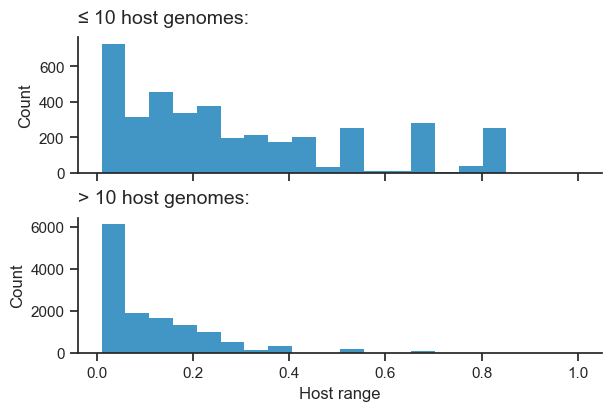

In [60]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=False, constrained_layout=True)
sns.histplot(
    [
        virus_host_dist_combined[votu]["median_dist"]
        for votu in virus_host_dist_combined
        if virus_host_dist_combined[votu]["n_host_genomes"] <= 10
    ],
    binrange=(0.01, 1),
    bins=20,
    lw=0,
    ax=ax[0],
)
sns.histplot(
    [
        virus_host_dist_combined[votu]["median_dist"]
        for votu in virus_host_dist_combined
        if virus_host_dist_combined[votu]["n_host_genomes"] > 10
    ],
    binrange=(0.01, 1),
    bins=20,
    lw=0,
    ax=ax[1],
)
ax[0].set_title("≤ 10 host genomes:", loc="left", size=14, pad=10)
ax[1].set_title("> 10 host genomes:", loc="left", size=14, pad=10)
ax[1].set_xlabel("Host range")

In [12]:
from typing import Sequence
import math

def find_cutoff(data: Sequence[float]) -> float:
    x = sorted(data)
    distances = []
    mb = x[-1] / len(x)
    bb = 0
    for xac in range(len(x)):
        yac = x[xac]
        bc = yac - (-1 / mb) * xac
        ycb = (bb + bc * mb**2) / (1 + mb**2)
        xcb = (ycb - bb) / mb
        d = math.sqrt((xcb - xac) ** 2 + (ycb - yac) ** 2)
        distances.append(d)
    max_index = distances.index(max(distances))
    return x[max_index]

In [ ]:
species_genus_cutoff = find_cutoff(
    [
        virus_host_dist_combined[votu]["median_dist"]
        for votu in virus_host_dist_combined
        if virus_host_dist_combined[votu]["n_host_genomes"] > 10
    ]
)
print(f"Species/genus cutoff: {species_genus_cutoff:.6f}")

Text(0.05, 0.135, 'Species/genus cutoff: 0.0189')

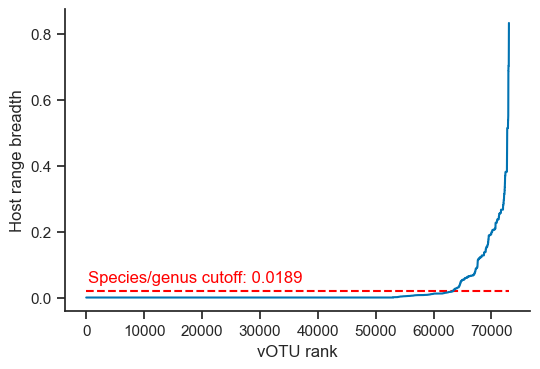

In [58]:
fig, ax = plt.subplots()
ax.plot(
    np.arange(
        sum(
            virus_host_dist_combined[votu]["n_host_genomes"] > 10
            for votu in virus_host_dist_combined
        )
    ),
    np.sort(
        [
            virus_host_dist_combined[votu]["median_dist"]
            for votu in virus_host_dist_combined
            if virus_host_dist_combined[votu]["n_host_genomes"] > 10
        ]
    ),
)
ax.hlines(
    species_genus_cutoff,
    0,
    sum(
        virus_host_dist_combined[votu]["n_host_genomes"] > 10
        for votu in virus_host_dist_combined
    ),
    color="red",
    linestyle="dashed",
)
ax.set_xlabel("vOTU rank")
ax.set_ylabel("Host range breadth")
ax.text(
    0.05,
    0.135,
    f"Species/genus cutoff: {species_genus_cutoff:.4f}",
    color="red",
    transform=ax.transAxes,
    verticalalignment="top",
    horizontalalignment="left",
)

The host range breadth values and corresponding discrete categorizations for each vOTU are written to the `phylogenetic_host_range_crispr.tsv`, `phylogenetic_host_range_kmer.tsv`, and `phylogenetic_host_range_combined.tsv` files.

In [62]:
# Distance between host genomes determined via CRISPR
with open("results/phylogenetic_host_range_crispr.tsv", "w") as fout:
    fout.write(
        "votu\tn_host_genomes\tmean\tmean_rank\tmedian\tmedian_rank\t"
        "q1\tq1_rank\tq3\tq3_rank\ttukey_biweight\ttukey_biweight_rank\n"
    )
    for virus, dists in virus_host_dist_crispr.items():
        mean_dist_rank = (
            classification_model.predict([dists["mean_dist"]])
            if dists["mean_dist"] >= species_genus_cutoff
            else "species"
        )
        median_dist_rank = (
            classification_model.predict([dists["median_dist"]])
            if dists["median_dist"] >= species_genus_cutoff
            else "species"
        )
        q1_dist_rank = (
            classification_model.predict([dists["q1_dist"]])
            if dists["q1_dist"] >= species_genus_cutoff
            else "species"
        )
        q3_dist_rank = (
            classification_model.predict([dists["q3_dist"]])
            if dists["q3_dist"] >= species_genus_cutoff
            else "species"
        )
        tukey_biweight_dist_rank = (
            classification_model.predict([dists["tukey_biweight_dist"]])
            if dists["tukey_biweight_dist"] >= species_genus_cutoff
            else "species"
        )
        fout.write(
            "\t".join(
                [
                    virus,
                    str(dists["n_host_genomes"]),
                    f"{dists['mean_dist']:.6f}",
                    mean_dist_rank,
                    f"{dists['median_dist']:.6f}",
                    median_dist_rank,
                    f"{dists['q1_dist']:.6f}",
                    q1_dist_rank,
                    f"{dists['q3_dist']:.6f}",
                    q3_dist_rank,
                    f"{dists['tukey_biweight_dist']:.6f}",
                    tukey_biweight_dist_rank,
                ]
            )
            + "\n"
        )
# Distance between host genomes determined via kmer matching
with open("results/phylogenetic_host_range_kmer.tsv", "w") as fout:
    fout.write(
        "votu\tn_host_genomes\tmean\tmean_rank\tmedian\tmedian_rank\t"
        "q1\tq1_rank\tq3\tq3_rank\ttukey_biweight\ttukey_biweight_rank\n"
    )
    for virus, dists in virus_host_dist_kmers.items():
        mean_dist_rank = (
            classification_model.predict([dists["mean_dist"]])
            if dists["mean_dist"] >= species_genus_cutoff
            else "species"
        )
        median_dist_rank = (
            classification_model.predict([dists["median_dist"]])
            if dists["median_dist"] >= species_genus_cutoff
            else "species"
        )
        q1_dist_rank = (
            classification_model.predict([dists["q1_dist"]])
            if dists["q1_dist"] >= species_genus_cutoff
            else "species"
        )
        q3_dist_rank = (
            classification_model.predict([dists["q3_dist"]])
            if dists["q3_dist"] >= species_genus_cutoff
            else "species"
        )
        tukey_biweight_dist_rank = (
            classification_model.predict([dists["tukey_biweight_dist"]])
            if dists["tukey_biweight_dist"] >= species_genus_cutoff
            else "species"
        )
        fout.write(
            "\t".join(
                [
                    virus,
                    str(dists["n_host_genomes"]),
                    f"{dists['mean_dist']:.6f}",
                    mean_dist_rank,
                    f"{dists['median_dist']:.6f}",
                    median_dist_rank,
                    f"{dists['q1_dist']:.6f}",
                    q1_dist_rank,
                    f"{dists['q3_dist']:.6f}",
                    q3_dist_rank,
                    f"{dists['tukey_biweight_dist']:.6f}",
                    tukey_biweight_dist_rank,
                ]
            )
            + "\n"
        )
# Combined distance between host genomes
with open("results/phylogenetic_host_range_combined.tsv", "w") as fout:
    fout.write(
        "votu\tn_host_genomes\tmean\tmean_rank\tmedian\tmedian_rank\tq1\t"
        "q1_rank\tq3\tq3_rank\ttukey_biweight\ttukey_biweight_rank\tmethod\n"
    )
    for virus, dists in virus_host_dist_combined.items():
        mean_dist_rank = (
            classification_model.predict([dists["mean_dist"]])
            if dists["mean_dist"] >= species_genus_cutoff
            else "species"
        )
        median_dist_rank = (
            classification_model.predict([dists["median_dist"]])
            if dists["median_dist"] >= species_genus_cutoff
            else "species"
        )
        q1_dist_rank = (
            classification_model.predict([dists["q1_dist"]])
            if dists["q1_dist"] >= species_genus_cutoff
            else "species"
        )
        q3_dist_rank = (
            classification_model.predict([dists["q3_dist"]])
            if dists["q3_dist"] >= species_genus_cutoff
            else "species"
        )
        tukey_biweight_dist_rank = (
            classification_model.predict([dists["tukey_biweight_dist"]])
            if dists["tukey_biweight_dist"] >= species_genus_cutoff
            else "species"
        )
        fout.write(
            "\t".join(
                [
                    virus,
                    str(dists["n_host_genomes"]),
                    f"{dists['mean_dist']:.6f}",
                    mean_dist_rank,
                    f"{dists['median_dist']:.6f}",
                    median_dist_rank,
                    f"{dists['q1_dist']:.6f}",
                    q1_dist_rank,
                    f"{dists['q3_dist']:.6f}",
                    q3_dist_rank,
                    f"{dists['tukey_biweight_dist']:.6f}",
                    tukey_biweight_dist_rank,
                    dists["method"],
                ]
            )
            + "\n"
        )

---

# Data exploration

The majority of vOTUs were assigned to host genomes using both methods. However, the CRISPR-based approach demonstrated greater sensitivity compared to the k-mer-based method, as evidenced by a larger number of vOTUs being exclusively linked to hosts through CRISPR spacers rather than through k-mer matching.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [7]:
host_range_crispr_df = pd.read_csv(
    "results/phylogenetic_host_range_crispr.tsv", sep="\t", index_col=0
)
host_range_kmers_df = pd.read_csv(
    "results/phylogenetic_host_range_kmer.tsv", sep="\t", index_col=0
)
host_range_combined_df = pd.read_csv(
    "results/phylogenetic_host_range_combined.tsv", sep="\t", index_col=0
)
votu_metadata = pd.read_csv("uhgv_data/votus_metadata.tsv", sep="\t", index_col=1)

In [8]:
n_both = len(set(host_range_crispr_df.index).intersection(host_range_kmers_df.index))
n_crispr_exclusive = len(
    set(host_range_crispr_df.index).difference(host_range_kmers_df.index)
)
n_kmer_exclusive = len(
    set(host_range_kmers_df.index).difference(host_range_crispr_df.index)
)
print(f"Detected by both methods:           {n_both:,}")
print(f"Exclusive to CRISPR-based approach: {n_crispr_exclusive:,}")
print(f"Exclusive to kmer-based approach:   {n_kmer_exclusive:,}")

Detected by both methods:           55,323
Exclusive to CRISPR-based approach: 30,233
Exclusive to kmer-based approach:   3,959


Among vOTUs linked to host genomes by both methods, the CRISPR-based approach was selected as the preferred method in most cases.

In [9]:
Counter(
    host_range_combined_df.loc[
        list(set(host_range_crispr_df.index).intersection(host_range_kmers_df.index)),
        "method",
    ]
)

Counter({'crispr_spacer': 43014, 'kmer_matching': 12309})

<Axes: xlabel='median_rank', ylabel='count'>

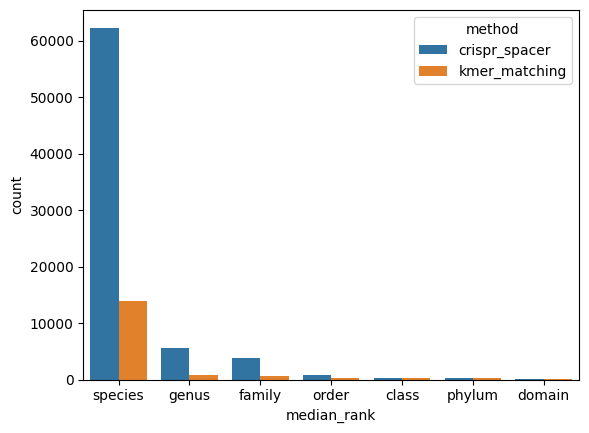

In [10]:
sns.countplot(
    host_range_combined_df,
    x="median_rank",
    hue="method",
    lw=0,
    order=["species", "genus", "family", "order", "class", "phylum", "domain"],
    hue_order=["crispr_spacer", "kmer_matching"],
)

For vOTUs linked to 6,000 or more host genomes, the majority of connections were made using the k-mer matching method. Consequently, these predictions might be less accurate and should be approached with caution.

In [11]:
Counter(host_range_combined_df.query("n_host_genomes > 6_000").method)

Counter({'kmer_matching': 436, 'crispr_spacer': 84})

<Axes: xlabel='n_host_genomes', ylabel='Count'>

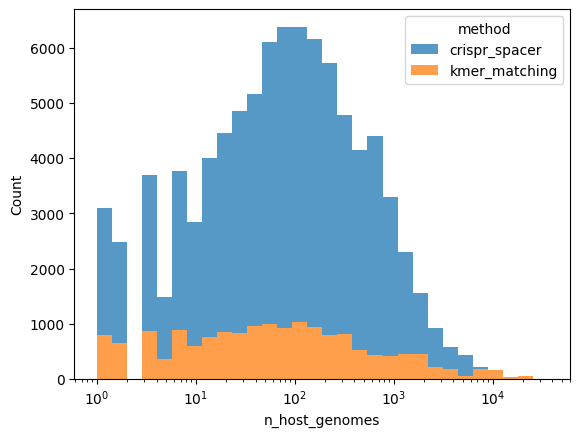

In [12]:
sns.histplot(
    host_range_combined_df,
    x="n_host_genomes",
    bins=30,
    hue="method",
    multiple="stack",
    hue_order=["crispr_spacer", "kmer_matching"],
    log_scale=True,
    lw=0,
)

Text(0.0, 1.0, 'Combined:')

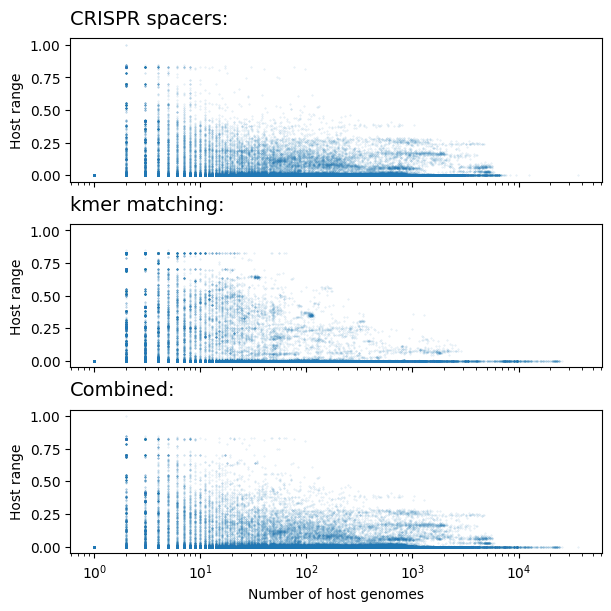

In [13]:
fig, ax = plt.subplots(
    nrows=3, figsize=(6, 6), sharex=True, sharey=True, constrained_layout=True
)
ax[0].scatter(
    host_range_crispr_df.n_host_genomes.values,
    host_range_crispr_df.tukey_biweight.values,
    s=0.1,
    alpha=0.2,
)
ax[1].scatter(
    host_range_kmers_df.n_host_genomes.values,
    host_range_kmers_df.tukey_biweight.values,
    s=0.1,
    alpha=0.2,
)
ax[2].scatter(
    host_range_combined_df.n_host_genomes.values,
    host_range_combined_df.tukey_biweight.values,
    s=0.1,
    alpha=0.2,
)
ax[2].set_xscale("log")
for a in ax:
    a.set_ylabel("Host range")
ax[2].set_xlabel("Number of host genomes")
ax[0].set_title("CRISPR spacers:", loc="left", size=14, pad=10)
ax[1].set_title("kmer matching:", loc="left", size=14, pad=10)
ax[2].set_title("Combined:", loc="left", size=14, pad=10)

In [ ]:
host_range_breadth_boundaries = [species_genus_cutoff]
preds = np.array([classification_model.predict(i) for i in np.linspace(0, 1, 10000)])
for r in ["genus", "family", "order", "class", "phylum", "domain"]:
    host_range_breadth_boundaries.append(max(np.linspace(0, 1, 10000)[preds == r]))

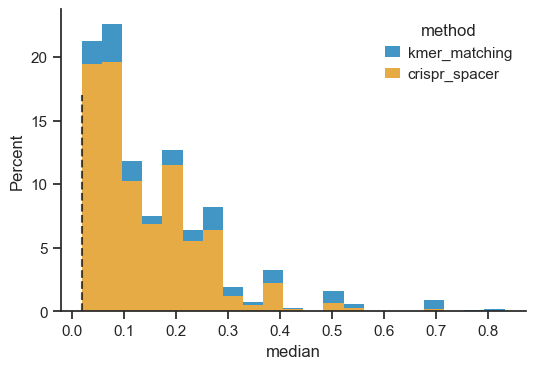

In [17]:
fig, ax = plt.subplots()
sns.histplot(
    data=host_range_combined_df.query("median_rank != 'species'")
    .query("n_host_genomes > 10")
    .query("n_host_genomes <= 6_000"),
    x="median",
    hue="method",
    multiple="stack",
    lw=0,
    bins=21,
    stat="percent",
    hue_order=["kmer_matching", "crispr_spacer"],
    ax=ax,
)
ax.vlines(
    host_range_breadth_boundaries,
    0,
    17,
    color="black",
    lw=1.5,
    linestyles="dashed",
    alpha=0.7,
)